# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f)) ##read_csv each of the files
    data[f.replace(".csv", "")] = d ##get rid of .CSV 后缀 and use file names as the names of the columns

#Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
## standardize the DBN code for every high school

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc) # look for "(,)" which includes the coordinates of the schools, at the same time escape the "()"
    lat = coords[0].split(",")[0].replace("(", "") # split the coordinates by "," get rid of "(", and first number is latitude
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean) # group by DBN number and calculate average class size for each school with unique DBN code 
class_size.reset_index(inplace=True) # reset index as a new [0, 1, 2, ..., X] and modify existing dataframe without creating new object
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012] # filter school year to be 20112012

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"] # filter Cohort to be 2006
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"] # filter "Demographic" to be "Total Cohort"

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left") # combine data["sat_results"] with data["ap_2010"], with DBN as benchmark, with Left Join
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner") # Inner join, combine 4 columns of data to "Combined"

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr() # find correlation of each two columns
correlations = correlations["sat_score"] # get the correlation of each colume with SAT score
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


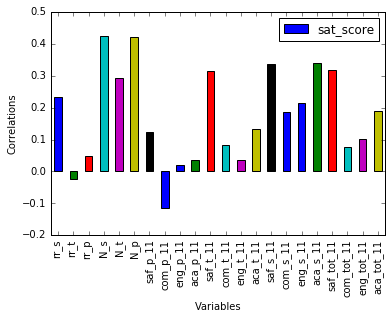

In [11]:
import matplotlib as plt
%matplotlib inline
fig_1 = correlations[survey_fields].plot.bar(y="Correlations", legend=True)
fig_1.set_xlabel("Variables")
fig_1.set_ylabel("Correlations")

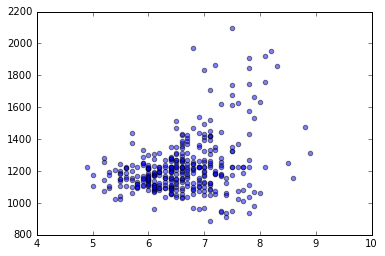

In [12]:
import matplotlib.pyplot as plt
x = combined["saf_s_11"]
y = combined["sat_score"]
plt.scatter(x, y, alpha=0.5)
plt.show()

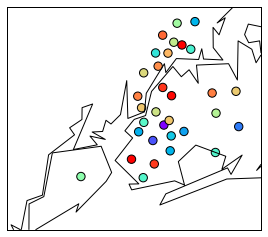

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
projection = 'merc',
llcrnrlat = 40.5, 
urcrnrlat = 40.9, 
llcrnrlon = -74.3, 
urcrnrlon = -73.7,
resolution='i')

m.drawcoastlines()
m.drawmapboundary()
m.drawrivers()

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

longtitude = districts["lon"].tolist()
latitude = districts["lat"].tolist()

m.scatter(longtitude, latitude, s=70, latlon=True, c=districts["saf_s_11"], cmap = "rainbow")
plt.show()

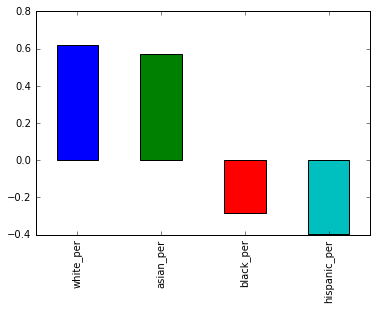

In [14]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

#white and Asian percentage appear to have positive correlation with SAT scores, while black and hispanic percenages seem to have negative correlations with SAT scores. 

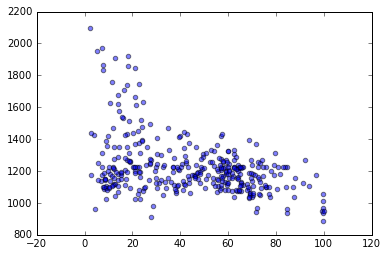

In [15]:
import matplotlib.pyplot as plt
x = combined["hispanic_per"]
y = combined["sat_score"]
plt.scatter(x, y, alpha=0.5)
plt.show()

In [16]:
print(combined[combined["hispanic_per"]>95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Majority of the schools are international schools for immigrant students who are still learning English. 

In [17]:
print(combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are focused on science and technology that received extra funding, and only admit students who passed an entrance exam. 

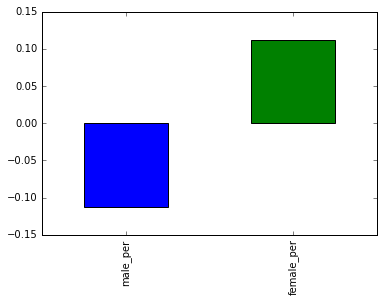

In [18]:
gender_fields = ["male_per", "female_per"]
#combined.corr()["sat_score"][gender_fields].plot.bar()
gender_df = combined.corr()["sat_score"][gender_fields]
gender_df.plot.bar()
plt.show()

Female percentage has a slightly positive correlation with SAT score, while male percentage has a slightly negative correlation with SAT score. 

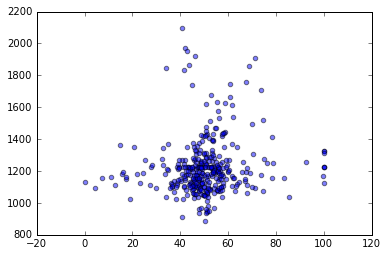

In [19]:
import matplotlib.pyplot as plt
x = combined["female_per"]
y = combined["sat_score"]
plt.scatter(x, y, alpha=0.5)
plt.show()

In [20]:
print(combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are highly selective liberal arts schools 

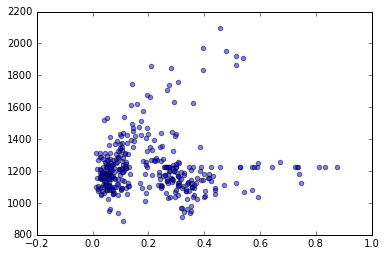

In [21]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
x = combined["ap_per"]
y = combined["sat_score"]
plt.scatter(x, y, alpha=0.5)
plt.show()

In [22]:
print(combined.corr()["sat_score"]["ap_per"])

0.05717081390766967


It doesn't seem to have a strong positive correlation between AP test enrollment and SAT score, 